NEW APPROACH

In [20]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

np.random.seed(42)

CSV_PATH = "/kaggle/input/behavioral-risk-factor-surveillance-system/2015.csv"

USECOLS = [
    'DIABETE3','_RFHYPE5','TOLDHI2','_CHOLCHK','_BMI5','SMOKE100',
    'CVDSTRK3','_MICHD','_TOTINDA','_FRTLT1','_VEGLT1','_RFDRHV5',
    'HLTHPLN1','MEDCOST','GENHLTH','MENTHLTH','PHYSHLTH','DIFFWALK',
    'SEX','_AGEG5YR','EDUCA','INCOME2'
]

# ---------------------------
# 0) Load + baseline metrics
# ---------------------------
raw = pd.read_csv(CSV_PATH, usecols=USECOLS, low_memory=False)
print("=== LOAD ===")
print(f"Raw shape: {raw.shape}")
print("Raw DIABETE3 (codes) value_counts:\n", raw['DIABETE3'].value_counts(dropna=False).sort_index())
print("-" * 60)

df = raw.copy()

def drop_report(df, mask_keep, desc):
    """Keep rows where mask_keep is True; report rows dropped."""
    before = len(df)
    df = df[mask_keep].copy()
    after = len(df)
    print(f"{desc}: kept {after} / dropped {before - after}")
    return df

# Keep a copy of BMI before rounding for comparison
_BMI5_before = df['_BMI5'].copy()

# ------------------------------------------
# 1) BRFSS recodes / drops (with logging)
# ------------------------------------------
print("=== CLEANING & RECODING ===")

# DIABETE3: valid codes (exclude 7,9), then map to {0,1,2} as in your script
df = drop_report(df, ~df['DIABETE3'].isin([7,9]), "DIABETE3 exclude {7,9}")
df['DIABETE3'] = df['DIABETE3'].replace({2:0, 3:0, 1:2, 4:1})
print("DIABETE3 (mapped to 0/1/2) value_counts:\n", df['DIABETE3'].value_counts().sort_index())

df = drop_report(df, df['_RFHYPE5'] != 9, "_RFHYPE5 != 9")
df['_RFHYPE5'] = df['_RFHYPE5'].replace({1:0, 2:1})

df = drop_report(df, ~df['TOLDHI2'].isin([7,9]), "TOLDHI2 exclude {7,9}")
df['TOLDHI2'] = df['TOLDHI2'].replace({2:0})

df = drop_report(df, df['_CHOLCHK'] != 9, "_CHOLCHK != 9")
df['_CHOLCHK'] = df['_CHOLCHK'].replace({2:0, 3:0})

# BMI rounding
print(f"_BMI5 before rounding (describe):\n{_BMI5_before.describe()}")
df['_BMI5'] = (df['_BMI5'] / 100).round(0)
print(f"BMI after rounding to nearest integer (describe):\n{df['_BMI5'].describe()}")

df = drop_report(df, ~df['SMOKE100'].isin([7,9]), "SMOKE100 exclude {7,9}")
df['SMOKE100'] = df['SMOKE100'].replace({2:0})

df = drop_report(df, ~df['CVDSTRK3'].isin([7,9]), "CVDSTRK3 exclude {7,9}")
df['CVDSTRK3'] = df['CVDSTRK3'].replace({2:0})

df['_MICHD'] = df['_MICHD'].replace({2:0})

df = drop_report(df, df['_TOTINDA'] != 9, "_TOTINDA != 9")
df['_TOTINDA'] = df['_TOTINDA'].replace({2:0})

df = drop_report(df, df['_FRTLT1'] != 9, "_FRTLT1 != 9")
df['_FRTLT1'] = df['_FRTLT1'].replace({2:0})

df = drop_report(df, df['_VEGLT1'] != 9, "_VEGLT1 != 9")
df['_VEGLT1'] = df['_VEGLT1'].replace({2:0})

df = drop_report(df, df['_RFDRHV5'] != 9, "_RFDRHV5 != 9")
df['_RFDRHV5'] = df['_RFDRHV5'].replace({1:0, 2:1})

df = drop_report(df, ~df['HLTHPLN1'].isin([7,9]), "HLTHPLN1 exclude {7,9}")
df['HLTHPLN1'] = df['HLTHPLN1'].replace({2:0})

df = drop_report(df, ~df['MEDCOST'].isin([7,9]), "MEDCOST exclude {7,9}")
df['MEDCOST'] = df['MEDCOST'].replace({2:0})

df = drop_report(df, ~df['GENHLTH'].isin([7,9]), "GENHLTH exclude {7,9}")

df['MENTHLTH'] = df['MENTHLTH'].replace({88:0})
df = drop_report(df, ~df['MENTHLTH'].isin([77,99]), "MENTHLTH exclude {77,99}")

df['PHYSHLTH'] = df['PHYSHLTH'].replace({88:0})
df = drop_report(df, ~df['PHYSHLTH'].isin([77,99]), "PHYSHLTH exclude {77,99}")

df = drop_report(df, ~df['DIFFWALK'].isin([7,9]), "DIFFWALK exclude {7,9}")
df['DIFFWALK'] = df['DIFFWALK'].replace({2:0})

df['SEX'] = df['SEX'].replace({2:0})
df = drop_report(df, df['_AGEG5YR'] != 14, "_AGEG5YR != 14")
df = drop_report(df, df['EDUCA'] != 9, "EDUCA != 9")
df = drop_report(df, ~df['INCOME2'].isin([77,99]), "INCOME2 exclude {77,99}")

before_na = len(df)
df = df.dropna()
print(f"dropna(): kept {len(df)} / dropped {before_na - len(df)}")

print("-" * 60)
print("Post-cleaning shape:", df.shape)

# ------------------------------------------
# 2) Rename columns (as in your script)
# ------------------------------------------
df = df.rename(columns={
    'DIABETE3':'Diabetes_012','_RFHYPE5':'HighBP','TOLDHI2':'HighChol','_CHOLCHK':'CholCheck',
    '_BMI5':'BMI','SMOKE100':'Smoker','CVDSTRK3':'Stroke','_MICHD':'HeartDiseaseorAttack',
    '_TOTINDA':'PhysActivity','_FRTLT1':'Fruits','_VEGLT1':'Veggies','_RFDRHV5':'HvyAlcoholConsump',
    'HLTHPLN1':'AnyHealthcare','MEDCOST':'NoDocbcCost','GENHLTH':'GenHlth','MENTHLTH':'MentHlth',
    'PHYSHLTH':'PhysHlth','DIFFWALK':'DiffWalk','SEX':'Sex','_AGEG5YR':'Age',
    'EDUCA':'Education','INCOME2':'Income'
})
print("Renamed columns. Sample columns:\n", list(df.columns))

# ------------------------------------------
# 3) Save cleaned MULTICLASS
# ------------------------------------------
multi_out = "/kaggle/working/diabetes_012_health_indicators_BRFSS2015.csv"
df.to_csv(multi_out, index=False)
print(f"Saved multiclass cleaned CSV → {multi_out}")
print("Diabetes_012 value_counts:\n", df['Diabetes_012'].value_counts().sort_index())
print("-" * 60)

# ------------------------------------------
# 4) Make BINARY (1 = prediabetes/diabetes)
# ------------------------------------------
bin_df = df.copy()
bin_df['Diabetes_binary'] = bin_df['Diabetes_012'].replace({0:0, 1:1, 2:1})
bin_df = bin_df.drop(columns=['Diabetes_012'])

bin_out = "/kaggle/working/diabetes_binary_health_indicators_BRFSS2015.csv"
bin_df.to_csv(bin_out, index=False)
print(f"Saved binary cleaned CSV → {bin_out}")
print("Binary target value_counts (real distribution):\n", bin_df['Diabetes_binary'].value_counts())
print("Binary target proportion:\n", (bin_df['Diabetes_binary'].value_counts(normalize=True).sort_index()))
print("-" * 60)

# ----------------------------------------------------------------
# 5) Stratified split (NO manual 70:30 dataset construction here)
# ----------------------------------------------------------------
X = bin_df.drop(columns=['Diabetes_binary'])
y = bin_df['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("=== SPLIT ===")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Train target counts:", Counter(y_train))
print("Test  target counts:", Counter(y_test))
print("Train target ratio:", {k: round(v/len(y_train), 4) for k, v in Counter(y_train).items()})
print("Test  target ratio:", {k: round(v/len(y_test), 4) for k, v in Counter(y_test).items()})
print("-" * 60)

# ----------------------------------------------------------------
# 6) OPTIONAL: Balance ONLY the training set with SMOTE (toggle)
# ----------------------------------------------------------------
USE_SMOTE = True

if USE_SMOTE:
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    print("=== SMOTE (TRAIN ONLY) ===")
    print("Before SMOTE:", Counter(y_train))
    print("After  SMOTE:", Counter(y_train_bal))
    # Optional: scale after resampling (if your models need it)
    scaler = StandardScaler(with_mean=False)  # with_mean=False if you plan to support sparse later
    X_train_bal_scaled = scaler.fit_transform(X_train_bal)
    X_test_scaled = scaler.transform(X_test)

    # Save balanced training set (unscaled) for reproducible experiments
    smote_train_out_X = "/kaggle/working/X_train_smote.csv"
    smote_train_out_y = "/kaggle/working/y_train_smote.csv"
    pd.DataFrame(X_train_bal, columns=X.columns).to_csv(smote_train_out_X, index=False)
    pd.DataFrame({"Diabetes_binary": y_train_bal}).to_csv(smote_train_out_y, index=False)
    print(f"Saved SMOTE-balanced train X → {smote_train_out_X}")
    print(f"Saved SMOTE-balanced train y → {smote_train_out_y}")
else:
    print("SMOTE disabled. Proceeding with original (stratified) train set.")

print("Saved all files in /kaggle/working/")


ModuleNotFoundError: No module named 'sklearn.utils._metadata_requests'

DATA PREPROCESSING 

In [21]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

CSV_PATH = "/kaggle/input/behavioral-risk-factor-surveillance-system/2015.csv"

USECOLS = [
    'DIABETE3','_RFHYPE5','TOLDHI2','_CHOLCHK','_BMI5','SMOKE100',
    'CVDSTRK3','_MICHD','_TOTINDA','_FRTLT1','_VEGLT1','_RFDRHV5',
    'HLTHPLN1','MEDCOST','GENHLTH','MENTHLTH','PHYSHLTH','DIFFWALK',
    'SEX','_AGEG5YR','EDUCA','INCOME2'
]

# ---------------------------
# 0) Load + baseline metrics
# ---------------------------
raw = pd.read_csv(CSV_PATH, usecols=USECOLS, low_memory=False)
print("=== LOAD ===")
print(f"Raw shape: {raw.shape}")
print("Raw DIABETE3 (codes) value_counts:\n", raw['DIABETE3'].value_counts(dropna=False).sort_index())
print("-" * 60)

df = raw.copy()

def drop_report(df, mask_keep, desc):
    """Keep rows where mask_keep is True; report rows dropped."""
    before = len(df)
    df = df[mask_keep].copy()
    after = len(df)
    print(f"{desc}: kept {after} / dropped {before - after}")
    return df

# Keep a copy of BMI before rounding for comparison
_BMI5_before = df['_BMI5'].copy()

# ------------------------------------------
# 1) BRFSS recodes / drops (with logging)
# ------------------------------------------
print("=== CLEANING & RECODING ===")

df = drop_report(df, ~df['DIABETE3'].isin([7,9]), "DIABETE3 exclude {7,9}")
df['DIABETE3'] = df['DIABETE3'].replace({2:0, 3:0, 1:2, 4:1})
print("DIABETE3 (mapped to 0/1/2) value_counts:\n", df['DIABETE3'].value_counts().sort_index())

df = drop_report(df, df['_RFHYPE5'] != 9, "_RFHYPE5 != 9")
df['_RFHYPE5'] = df['_RFHYPE5'].replace({1:0, 2:1})

df = drop_report(df, ~df['TOLDHI2'].isin([7,9]), "TOLDHI2 exclude {7,9}")
df['TOLDHI2'] = df['TOLDHI2'].replace({2:0})

df = drop_report(df, df['_CHOLCHK'] != 9, "_CHOLCHK != 9")
df['_CHOLCHK'] = df['_CHOLCHK'].replace({2:0, 3:0})

print(f"_BMI5 before rounding (describe):\n{_BMI5_before.describe()}")
df['_BMI5'] = (df['_BMI5'] / 100).round(0)
print(f"BMI after rounding to nearest integer (describe):\n{df['_BMI5'].describe()}")

df = drop_report(df, ~df['SMOKE100'].isin([7,9]), "SMOKE100 exclude {7,9}")
df['SMOKE100'] = df['SMOKE100'].replace({2:0})

df = drop_report(df, ~df['CVDSTRK3'].isin([7,9]), "CVDSTRK3 exclude {7,9}")
df['CVDSTRK3'] = df['CVDSTRK3'].replace({2:0})

df['_MICHD'] = df['_MICHD'].replace({2:0})

df = drop_report(df, df['_TOTINDA'] != 9, "_TOTINDA != 9")
df['_TOTINDA'] = df['_TOTINDA'].replace({2:0})

df = drop_report(df, df['_FRTLT1'] != 9, "_FRTLT1 != 9")
df['_FRTLT1'] = df['_FRTLT1'].replace({2:0})

df = drop_report(df, df['_VEGLT1'] != 9, "_VEGLT1 != 9")
df['_VEGLT1'] = df['_VEGLT1'].replace({2:0})

df = drop_report(df, df['_RFDRHV5'] != 9, "_RFDRHV5 != 9")
df['_RFDRHV5'] = df['_RFDRHV5'].replace({1:0, 2:1})

df = drop_report(df, ~df['HLTHPLN1'].isin([7,9]), "HLTHPLN1 exclude {7,9}")
df['HLTHPLN1'] = df['HLTHPLN1'].replace({2:0})

df = drop_report(df, ~df['MEDCOST'].isin([7,9]), "MEDCOST exclude {7,9}")
df['MEDCOST'] = df['MEDCOST'].replace({2:0})

df = drop_report(df, ~df['GENHLTH'].isin([7,9]), "GENHLTH exclude {7,9}")

df['MENTHLTH'] = df['MENTHLTH'].replace({88:0})
df = drop_report(df, ~df['MENTHLTH'].isin([77,99]), "MENTHLTH exclude {77,99}")

df['PHYSHLTH'] = df['PHYSHLTH'].replace({88:0})
df = drop_report(df, ~df['PHYSHLTH'].isin([77,99]), "PHYSHLTH exclude {77,99}")

df = drop_report(df, ~df['DIFFWALK'].isin([7,9]), "DIFFWALK exclude {7,9}")
df['DIFFWALK'] = df['DIFFWALK'].replace({2:0})

df['SEX'] = df['SEX'].replace({2:0})
df = drop_report(df, df['_AGEG5YR'] != 14, "_AGEG5YR != 14")
df = drop_report(df, df['EDUCA'] != 9, "EDUCA != 9")
df = drop_report(df, ~df['INCOME2'].isin([77,99]), "INCOME2 exclude {77,99}")

before_na = len(df)
df = df.dropna()
print(f"dropna(): kept {len(df)} / dropped {before_na - len(df)}")

print("-" * 60)
print("Post-cleaning shape:", df.shape)

# ------------------------------------------
# 2) Rename columns 
# ------------------------------------------
df = df.rename(columns={
    'DIABETE3':'Diabetes_012','_RFHYPE5':'HighBP','TOLDHI2':'HighChol','_CHOLCHK':'CholCheck',
    '_BMI5':'BMI','SMOKE100':'Smoker','CVDSTRK3':'Stroke','_MICHD':'HeartDiseaseorAttack',
    '_TOTINDA':'PhysActivity','_FRTLT1':'Fruits','_VEGLT1':'Veggies','_RFDRHV5':'HvyAlcoholConsump',
    'HLTHPLN1':'AnyHealthcare','MEDCOST':'NoDocbcCost','GENHLTH':'GenHlth','MENTHLTH':'MentHlth',
    'PHYSHLTH':'PhysHlth','DIFFWALK':'DiffWalk','SEX':'Sex','_AGEG5YR':'Age',
    'EDUCA':'Education','INCOME2':'Income'
})
print("Renamed columns. Sample columns:\n", list(df.columns))

# ------------------------------------------
# 3) Save cleaned MULTICLASS
# ------------------------------------------
multi_out = "/kaggle/working/diabetes_012_health_indicators_BRFSS2015.csv"
df.to_csv(multi_out, index=False)
print(f"Saved multiclass cleaned CSV → {multi_out}")
print("Diabetes_012 value_counts:\n", df['Diabetes_012'].value_counts().sort_index())
print("-" * 60)

# ------------------------------------------
# 4) Make BINARY (1 = prediabetes/diabetes)
# ------------------------------------------
bin_df = df.copy()
bin_df['Diabetes_binary'] = bin_df['Diabetes_012'].replace({0:0, 1:1, 2:1})
bin_df = bin_df.drop(columns=['Diabetes_012'])

bin_out = "/kaggle/working/diabetes_binary_health_indicators_BRFSS2015.csv"
bin_df.to_csv(bin_out, index=False)
print(f"Saved binary cleaned CSV → {bin_out}")
print("Binary target value_counts (real distribution):\n", bin_df['Diabetes_binary'].value_counts())
print("Binary target proportion:\n", (bin_df['Diabetes_binary'].value_counts(normalize=True).sort_index()))
print("-" * 60)

# ----------------------------------------------------------------
# 5) Stratified split (NO manual 70:30 dataset construction)
# ----------------------------------------------------------------
X = bin_df.drop(columns=['Diabetes_binary'])
y = bin_df['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("=== SPLIT ===")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Train target counts:", Counter(y_train))
print("Test  target counts:", Counter(y_test))
print("Train target ratio:", {k: round(v/len(y_train), 4) for k, v in Counter(y_train).items()})
print("Test  target ratio:", {k: round(v/len(y_test), 4) for k, v in Counter(y_test).items()})
print("-" * 60)

# ----------------------------------------------------------------
# 6) Balance ONLY the training set (no external libs)
#    A) Random Over-Sampling  (duplicate minority)
#    B) Random Under-Sampling (trim majority)
# ----------------------------------------------------------------
def make_over_sampled_train(X_tr, y_tr):
    train = X_tr.copy()
    train['Diabetes_binary'] = y_tr.values
    counts = train['Diabetes_binary'].value_counts()
    maj_class = counts.idxmax()
    min_class = counts.idxmin()
    n_major = counts.max()
    n_minor = counts.min()

    # sample minority with replacement to match majority size
    minority_df = train[train['Diabetes_binary'] == min_class]
    majority_df = train[train['Diabetes_binary'] == maj_class]
    needed = n_major - n_minor
    boot = minority_df.sample(n=needed, replace=True, random_state=42)
    over_df = pd.concat([majority_df, minority_df, boot], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

    X_over = over_df.drop(columns=['Diabetes_binary'])
    y_over = over_df['Diabetes_binary']
    return X_over, y_over

def make_under_sampled_train(X_tr, y_tr):
    train = X_tr.copy()
    train['Diabetes_binary'] = y_tr.values
    counts = train['Diabetes_binary'].value_counts()
    maj_class = counts.idxmax()
    min_class = counts.idxmin()
    n_minor = counts.min()

    # sample majority without replacement down to minority size
    minority_df = train[train['Diabetes_binary'] == min_class]
    majority_df = train[train['Diabetes_binary'] == maj_class].sample(n=n_minor, replace=False, random_state=42)
    under_df = pd.concat([majority_df, minority_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

    X_under = under_df.drop(columns=['Diabetes_binary'])
    y_under = under_df['Diabetes_binary']
    return X_under, y_under

X_train_over, y_train_over = make_over_sampled_train(X_train, y_train)
X_train_under, y_train_under = make_under_sampled_train(X_train, y_train)

print("=== BALANCING (TRAIN ONLY) ===")
print("Original train counts:", Counter(y_train))
print("Over-sampled train counts:", Counter(y_train_over))
print("Under-sampled train counts:", Counter(y_train_under))

# Optional: scale after resampling if your models benefit from scaling
scaler = StandardScaler()
X_train_over_scaled  = scaler.fit_transform(X_train_over)
X_train_under_scaled = scaler.fit_transform(X_train_under)
X_test_scaled        = scaler.fit_transform(X_test)  # for fairness, fit on train in real pipelines

# Save balanced training sets (unscaled) for reproducible experiments
over_X_out = "/kaggle/working/X_train_over.csv"
over_y_out = "/kaggle/working/y_train_over.csv"
under_X_out = "/kaggle/working/X_train_under.csv"
under_y_out = "/kaggle/working/y_train_under.csv"

pd.DataFrame(X_train_over,  columns=X.columns).to_csv(over_X_out, index=False)
pd.DataFrame({"Diabetes_binary": y_train_over}).to_csv(over_y_out, index=False)

pd.DataFrame(X_train_under, columns=X.columns).to_csv(under_X_out, index=False)
pd.DataFrame({"Diabetes_binary": y_train_under}).to_csv(under_y_out, index=False)

print(f"Saved OVER-sampled train → {over_X_out} / {over_y_out}")
print(f"Saved UNDER-sampled train → {under_X_out} / {under_y_out}")
print("Saved all files in /kaggle/working/")


=== LOAD ===
Raw shape: (441456, 22)
Raw DIABETE3 (codes) value_counts:
 DIABETE3
1.0     57256
2.0      3608
3.0    372104
4.0      7690
7.0       598
9.0       193
NaN         7
Name: count, dtype: int64
------------------------------------------------------------
=== CLEANING & RECODING ===


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


DIABETE3 exclude {7,9}: kept 440665 / dropped 791
DIABETE3 (mapped to 0/1/2) value_counts:
 DIABETE3
0.0    375712
1.0      7690
2.0     57256
Name: count, dtype: int64
_RFHYPE5 != 9: kept 439407 / dropped 1258
TOLDHI2 exclude {7,9}: kept 436136 / dropped 3271
_CHOLCHK != 9: kept 421422 / dropped 14714
_BMI5 before rounding (describe):
count    405058.000000
mean       2804.242400
std         665.463433
min        1202.000000
25%        2373.000000
50%        2695.000000
75%        3090.000000
max        9995.000000
Name: _BMI5, dtype: float64
BMI after rounding to nearest integer (describe):
count    387818.000000
mean         28.066119
std           6.647624
min          12.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          98.000000
Name: _BMI5, dtype: float64
SMOKE100 exclude {7,9}: kept 418475 / dropped 2947
CVDSTRK3 exclude {7,9}: kept 417464 / dropped 1011
_TOTINDA != 9: kept 383139 / dropped 34325
_FRTLT1 != 9: kept 372733 / dropped 10406
_

EXPLORATORY DATA ANALYSIS

Shape of dataset: (253680, 22)

Columns:
 ['GenHlth', 'PhysHlth', 'MentHlth', 'AnyHealthcare', 'NoDocbcCost', 'HighChol', 'Stroke', 'Sex', 'Education', 'Income', 'DiffWalk', 'Smoker', 'HighBP', 'CholCheck', 'HeartDiseaseorAttack', 'Age', 'BMI', 'HvyAlcoholConsump', 'Fruits', 'Veggies', 'PhysActivity', 'Diabetes_binary']

=== Missing Values ===
GenHlth                 0
PhysHlth                0
MentHlth                0
AnyHealthcare           0
NoDocbcCost             0
HighChol                0
Stroke                  0
Sex                     0
Education               0
Income                  0
DiffWalk                0
Smoker                  0
HighBP                  0
CholCheck               0
HeartDiseaseorAttack    0
Age                     0
BMI                     0
HvyAlcoholConsump       0
Fruits                  0
Veggies                 0
PhysActivity            0
Diabetes_binary         0
dtype: int64

=== Data Types ===
float64    22
Name: count, dtype: int64

=== Basi

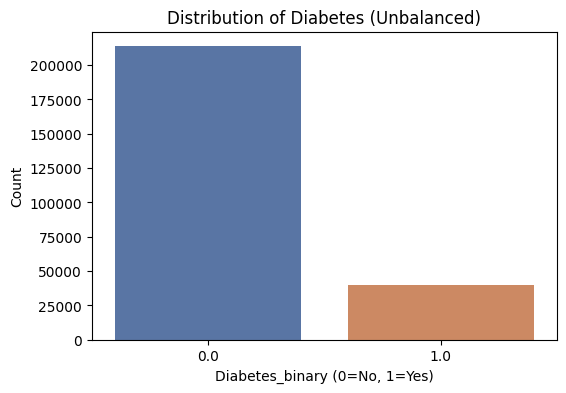

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


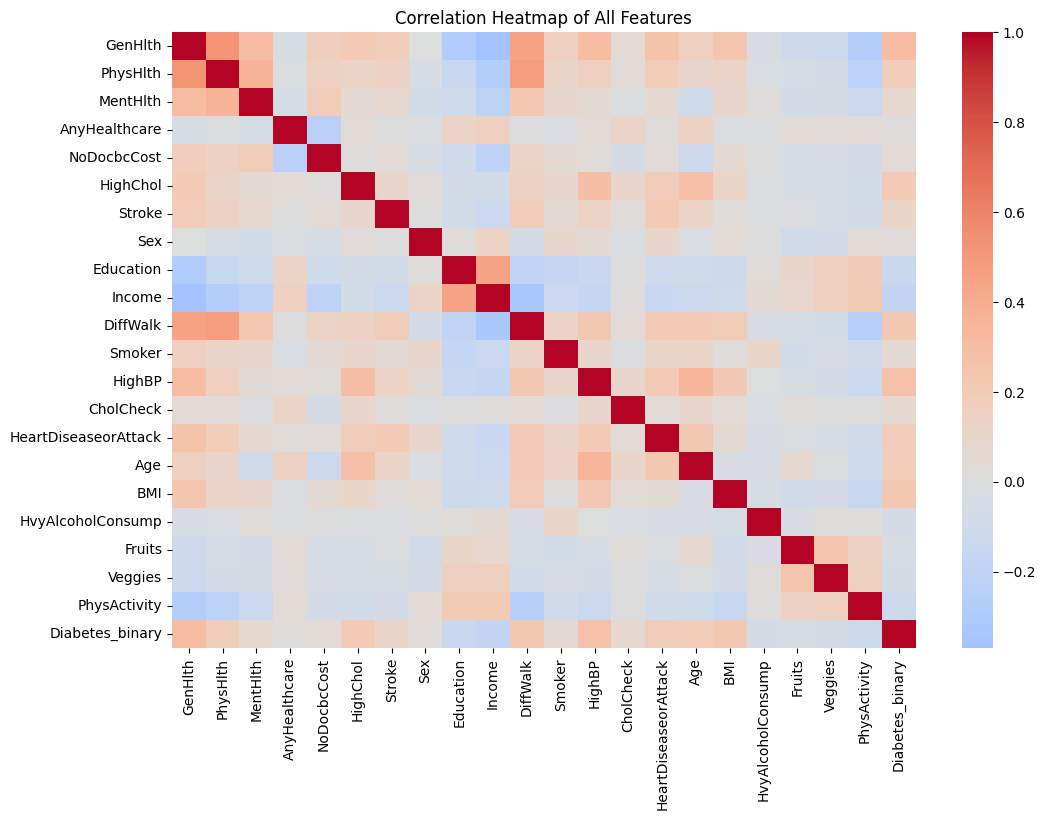

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

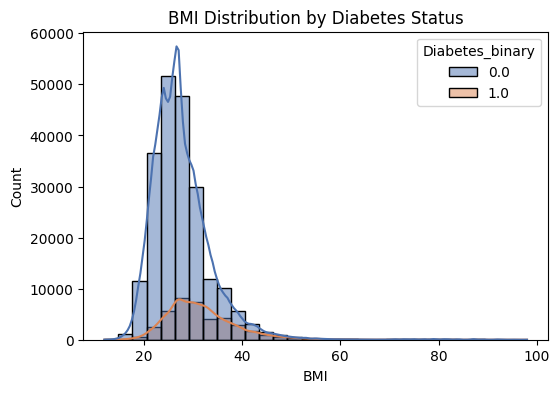

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

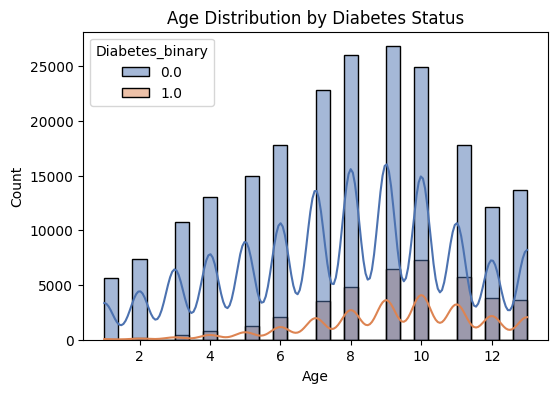

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

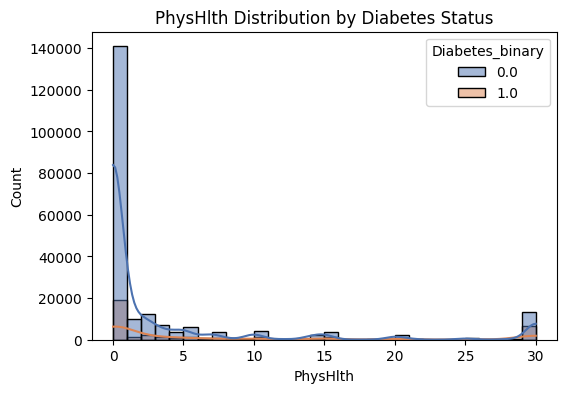

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

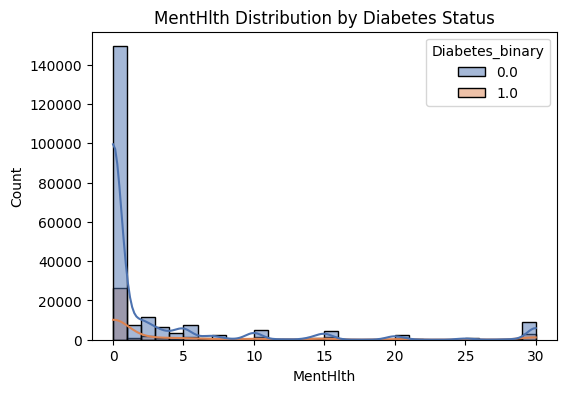

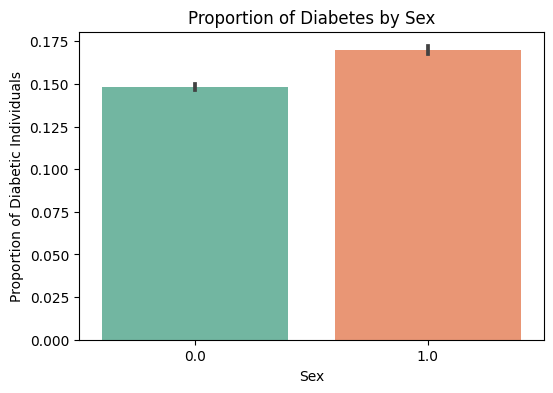

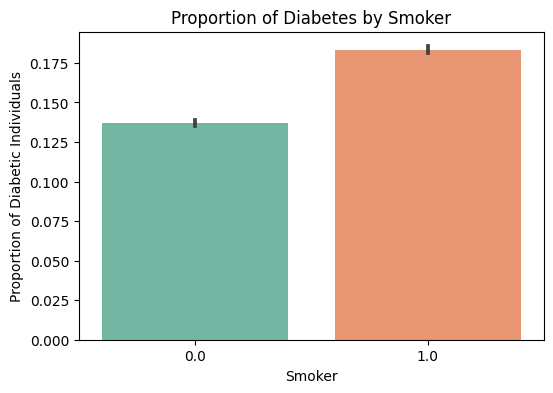

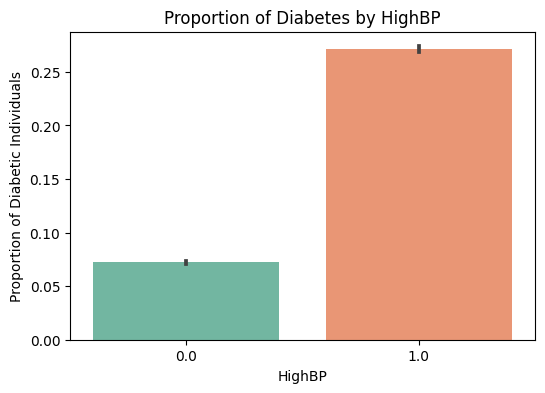

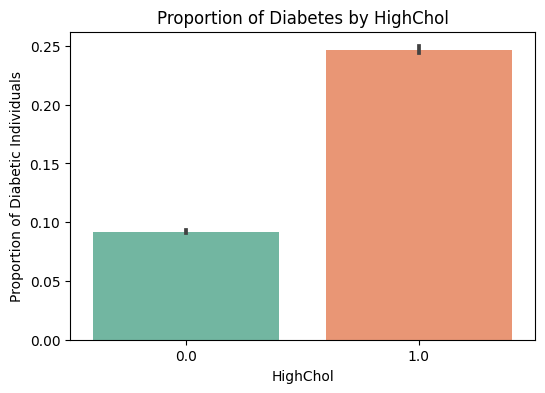

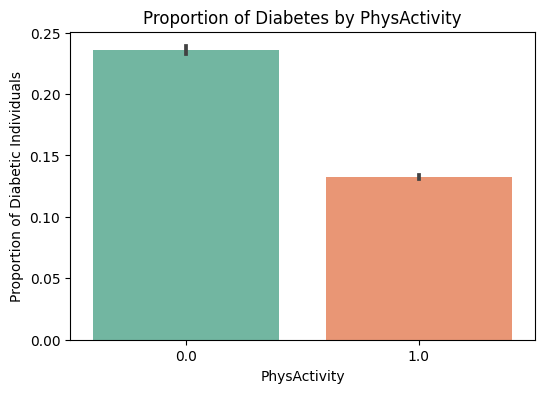

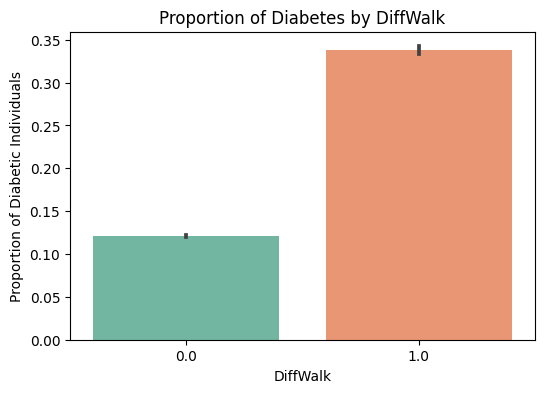

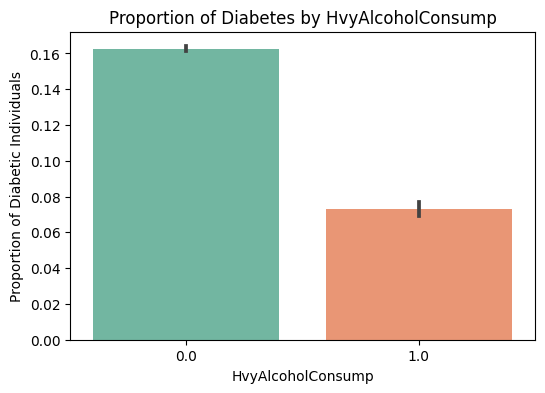

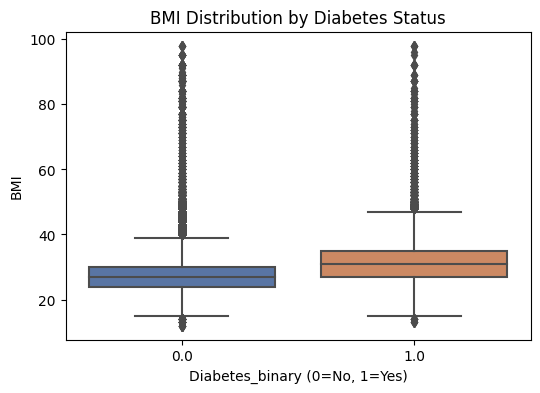

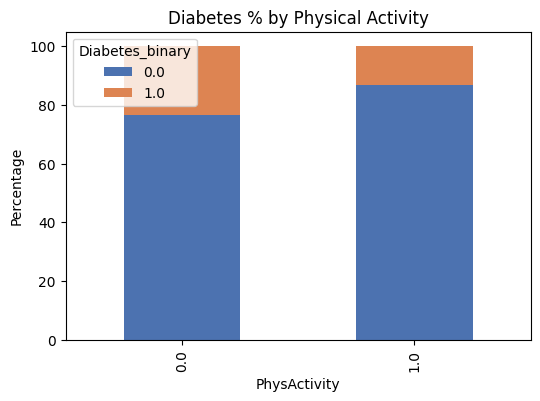

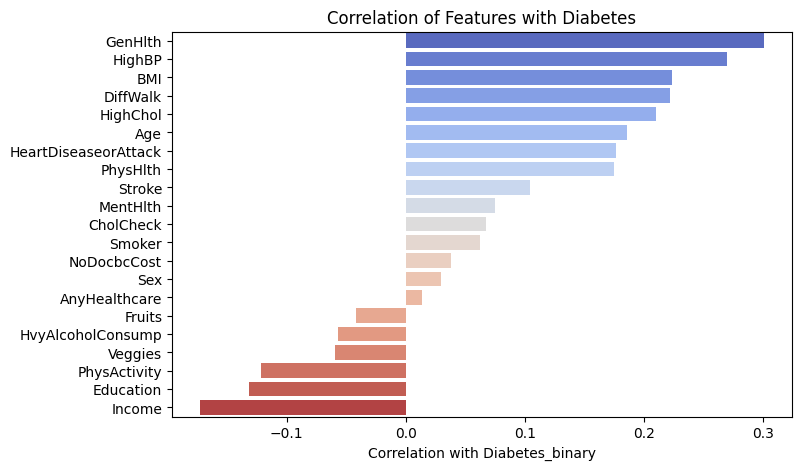


=== Key EDA Insights ===
1. Dataset is unbalanced (~84% non-diabetic, ~16% diabetic).
2. BMI, HighBP, and HighChol are positively correlated with diabetes.
3. Physical activity and general health are inversely correlated with diabetes.
4. No missing values after cleaning, 253k samples, 22 attributes.
5. EDA shows clear lifestyle–health relationships that motivate hypothesis testing.


In [22]:
# ===============================
# Exploratory Data Analysis (EDA)
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming bin_df is already loaded:
# bin_df = your cleaned binary dataset (unbalanced)
print("Shape of dataset:", bin_df.shape)
print("\nColumns:\n", list(bin_df.columns))

# -------------------------------------------------
# 1️⃣ Basic info and summary statistics
# -------------------------------------------------
print("\n=== Missing Values ===")
print(bin_df.isnull().sum())

print("\n=== Data Types ===")
print(bin_df.dtypes.value_counts())

print("\n=== Basic Statistics ===")
print(bin_df.describe().T)

# -------------------------------------------------
# 2️⃣ Target variable distribution
# -------------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='Diabetes_binary', data=bin_df, palette=['#4c72b0', '#dd8452'])
plt.title("Distribution of Diabetes (Unbalanced)")
plt.xlabel("Diabetes_binary (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()

# -------------------------------------------------
# 3️⃣ Correlation Heatmap (numerical features)
# -------------------------------------------------
plt.figure(figsize=(12,8))
corr = bin_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap of All Features")
plt.show()

# -------------------------------------------------
# 4️⃣ Feature distributions (continuous)
# -------------------------------------------------
continuous_features = ['BMI', 'Age', 'PhysHlth', 'MentHlth']
for col in continuous_features:
    plt.figure(figsize=(6,4))
    sns.histplot(data=bin_df, x=col, hue='Diabetes_binary', kde=True, bins=30, palette=['#4c72b0', '#dd8452'])
    plt.title(f"{col} Distribution by Diabetes Status")
    plt.show()

# -------------------------------------------------
# 5️⃣ Categorical variable comparisons
# -------------------------------------------------
categorical_features = ['Sex', 'Smoker', 'HighBP', 'HighChol', 'PhysActivity', 'DiffWalk', 'HvyAlcoholConsump']
for col in categorical_features:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y='Diabetes_binary', data=bin_df, estimator=np.mean, palette='Set2')
    plt.title(f"Proportion of Diabetes by {col}")
    plt.ylabel("Proportion of Diabetic Individuals")
    plt.show()

# -------------------------------------------------
# 6️⃣ Relationship examples for hypothesis ideas
# -------------------------------------------------
# Example: Average BMI by diabetes status
plt.figure(figsize=(6,4))
sns.boxplot(x='Diabetes_binary', y='BMI', data=bin_df, palette=['#4c72b0', '#dd8452'])
plt.title("BMI Distribution by Diabetes Status")
plt.xlabel("Diabetes_binary (0=No, 1=Yes)")
plt.ylabel("BMI")
plt.show()

# Example: Physical activity vs diabetes rate
activity_table = pd.crosstab(bin_df['PhysActivity'], bin_df['Diabetes_binary'], normalize='index') * 100
activity_table.plot(kind='bar', stacked=True, color=['#4c72b0','#dd8452'], figsize=(6,4))
plt.title("Diabetes % by Physical Activity")
plt.ylabel("Percentage")
plt.show()

# -------------------------------------------------
# 7️⃣ Correlation with target
# -------------------------------------------------
target_corr = corr['Diabetes_binary'].drop('Diabetes_binary').sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title("Correlation of Features with Diabetes")
plt.xlabel("Correlation with Diabetes_binary")
plt.show()

# -------------------------------------------------
# 8️⃣ Summary insights
# -------------------------------------------------
print("\n=== Key EDA Insights ===")
print("1. Dataset is unbalanced (~84% non-diabetic, ~16% diabetic).")
print("2. BMI, HighBP, and HighChol are positively correlated with diabetes.")
print("3. Physical activity and general health are inversely correlated with diabetes.")
print("4. No missing values after cleaning, 253k samples, 22 attributes.")
print("5. EDA shows clear lifestyle–health relationships that motivate hypothesis testing.")


Hypothesis Testing

In [23]:
# ============================================================
# Hypothesis Testing on Unbalanced Dataset (bin_df)
# Uses real (unbalanced) data for statistical validity
# Tests included:
# 1) BMI vs Diabetes (Welch's t-test, numeric vs binary)
# 2) PhysActivity vs Diabetes (Chi-square, categorical vs categorical)
# 3) Smoker vs Diabetes (Chi-square, categorical vs categorical)
# 4) HighBP vs Diabetes (Fisher's Exact Test, 2x2 categorical)
# 5) GenHlth vs Diabetes (Mann–Whitney U, ordinal vs binary)
# Alpha = 0.05 for significance
# ============================================================

import pandas as pd
import numpy as np
from pathlib import Path

from scipy.stats import ttest_ind, chi2_contingency, fisher_exact, mannwhitneyu

# ------------------------------------------------------------
# Load dataset: use in-memory bin_df if present, else read CSV
# ------------------------------------------------------------
if "bin_df" in globals():
    df = bin_df.copy()
else:
    csv_path = "/kaggle/working/diabetes_binary_health_indicators_BRFSS2015.csv"
    if not Path(csv_path).exists():
        raise FileNotFoundError(
            "Could not find '/kaggle/working/diabetes_binary_health_indicators_BRFSS2015.csv'. "
            "Please save your cleaned binary CSV before running hypothesis tests."
        )
    df = pd.read_csv(csv_path)

# Ensure expected columns exist
required_cols = [
    "Diabetes_binary", "BMI", "PhysActivity", "Smoker",
    "HighBP", "GenHlth"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ------------------------------------------------------------
# Basic info
# ------------------------------------------------------------
print("=== DATA SUMMARY ===")
print(f"Shape: {df.shape}")
print("Target distribution (Diabetes_binary):")
print(df["Diabetes_binary"].value_counts().sort_index())
print("Proportions:")
print(df["Diabetes_binary"].value_counts(normalize=True).sort_index())
print("-" * 60)

alpha = 0.05

def conclusion(p, alpha=0.05):
    return "Reject H0 (Significant)" if p < alpha else "Fail to reject H0 (Not significant)"

# ============================================================
# 1) BMI vs Diabetes — Welch's t-test
# H0: Mean BMI is equal in diabetic and non-diabetic groups
# H1: Mean BMI differs between groups
# ============================================================
print("TEST 1: BMI vs Diabetes (Welch's t-test)")
g0 = df.loc[df["Diabetes_binary"] == 0, "BMI"].dropna()
g1 = df.loc[df["Diabetes_binary"] == 1, "BMI"].dropna()

t_stat, p_val = ttest_ind(g0, g1, equal_var=False)
print(f"n0={len(g0)}, mean0={g0.mean():.3f}, std0={g0.std(ddof=1):.3f}")
print(f"n1={len(g1)}, mean1={g1.mean():.3f}, std1={g1.std(ddof=1):.3f}")
print(f"T-statistic={t_stat:.4f}, P-value={p_val:.4e}")
print(f"Conclusion: {conclusion(p_val, alpha)}")
print("-" * 60)

=== DATA SUMMARY ===
Shape: (253680, 22)
Target distribution (Diabetes_binary):
Diabetes_binary
0.0    213703
1.0     39977
Name: count, dtype: int64
Proportions:
Diabetes_binary
0.0    0.842412
1.0    0.157588
Name: proportion, dtype: float64
------------------------------------------------------------
TEST 1: BMI vs Diabetes (Welch's t-test)
n0=213703, mean0=27.743, std0=6.261
n1=39977, mean1=31.803, std1=7.329
T-statistic=-103.9055, P-value=0.0000e+00
Conclusion: Reject H0 (Significant)
------------------------------------------------------------


In [24]:

# ============================================================
# 2) PhysActivity vs Diabetes — Chi-square test of independence
# H0: PhysActivity and Diabetes are independent
# H1: They are associated
# ============================================================
print("TEST 2: PhysActivity vs Diabetes (Chi-square test)")
ct_pa = pd.crosstab(df["PhysActivity"], df["Diabetes_binary"])
chi2, p_pa, dof_pa, exp_pa = chi2_contingency(ct_pa)

print("Contingency table (rows=PhysActivity, cols=Diabetes_binary):")
print(ct_pa)
print(f"Chi-square={chi2:.4f}, dof={dof_pa}, P-value={p_pa:.4e}")
print(f"Conclusion: {conclusion(p_pa, alpha)}")
print("-" * 60)

TEST 2: PhysActivity vs Diabetes (Chi-square test)
Contingency table (rows=PhysActivity, cols=Diabetes_binary):
Diabetes_binary     0.0    1.0
PhysActivity                  
0.0               47212  14548
1.0              166491  25429
Chi-square=3737.4488, dof=1, P-value=0.0000e+00
Conclusion: Reject H0 (Significant)
------------------------------------------------------------


In [26]:

# ============================================================
# 3) Smoker vs Diabetes — Chi-square test of independence
# H0: Smoking and Diabetes are independent
# H1: They are associated
# ============================================================
print("TEST 3: Smoker vs Diabetes (Chi-square test)")
ct_sm = pd.crosstab(df["Smoker"], df["Diabetes_binary"])
chi2_sm, p_sm, dof_sm, exp_sm = chi2_contingency(ct_sm)

print("Contingency table (rows=Smoker, cols=Diabetes_binary):")
print(ct_sm)
print(f"Chi-square={chi2_sm:.4f}, dof={dof_sm}, P-value={p_sm:.4e}")
print(f"Conclusion: {conclusion(p_sm, alpha)}")
print("-" * 60)

TEST 3: Smoker vs Diabetes (Chi-square test)
Contingency table (rows=Smoker, cols=Diabetes_binary):
Diabetes_binary     0.0    1.0
Smoker                        
0.0              121879  19378
1.0               91824  20599
Chi-square=999.4148, dof=1, P-value=2.4070e-219
Conclusion: Reject H0 (Significant)
------------------------------------------------------------


In [27]:

# ============================================================
# 4) HighBP vs Diabetes — Fisher's Exact Test (2x2)
# H0: Odds of Diabetes are the same regardless of HighBP
# H1: Odds differ
# Note: Fisher's test expects a 2x2 table with binary variables.
# ============================================================
print("TEST 4: HighBP vs Diabetes (Fisher's Exact Test)")
ct_bp = pd.crosstab(df["HighBP"], df["Diabetes_binary"])
if ct_bp.shape != (2, 2):
    raise ValueError("HighBP or Diabetes_binary is not strictly binary for Fisher's test.")
oddsratio, p_bp = fisher_exact(ct_bp.values)

print("2x2 table (rows=HighBP 0/1, cols=Diabetes_binary 0/1):")
print(ct_bp)
print(f"Odds ratio={oddsratio:.4f}, P-value={p_bp:.4e}")
print(f"Conclusion: {conclusion(p_bp, alpha)}")
print("-" * 60)

TEST 4: HighBP vs Diabetes (Fisher's Exact Test)
2x2 table (rows=HighBP 0/1, cols=Diabetes_binary 0/1):
Diabetes_binary     0.0    1.0
HighBP                        
0.0              134391  10460
1.0               79312  29517
Odds ratio=4.7816, P-value=0.0000e+00
Conclusion: Reject H0 (Significant)
------------------------------------------------------------


In [28]:

# ============================================================
# 5) GenHlth vs Diabetes — Mann–Whitney U test (ordinal vs binary)
# H0: Distribution of GenHlth is the same in both groups
# H1: Distributions differ
# GenHlth: 1=Excellent ... 5=Poor (ordinal)
# ============================================================
print("TEST 5: GenHlth vs Diabetes (Mann–Whitney U)")
gh0 = df.loc[df["Diabetes_binary"] == 0, "GenHlth"].dropna()
gh1 = df.loc[df["Diabetes_binary"] == 1, "GenHlth"].dropna()

u_stat, p_mw = mannwhitneyu(gh0, gh1, alternative="two-sided")
print(f"n0={len(gh0)}, median0={np.median(gh0):.3f}")
print(f"n1={len(gh1)}, median1={np.median(gh1):.3f}")
print(f"U-statistic={u_stat:.4f}, P-value={p_mw:.4e}")
print(f"Conclusion: {conclusion(p_mw, alpha)}")
print("-" * 60)


TEST 5: GenHlth vs Diabetes (Mann–Whitney U)
n0=213703, median0=2.000
n1=39977, median1=3.000
U-statistic=2349291361.5000, P-value=0.0000e+00
Conclusion: Reject H0 (Significant)
------------------------------------------------------------


In [29]:
summary_rows = [
    ["BMI vs Diabetes",           "Welch t-test",          p_val],
    ["PhysActivity vs Diabetes",  "Chi-square",            p_pa],
    ["Smoker vs Diabetes",        "Chi-square",            p_sm],
    ["HighBP vs Diabetes",        "Fisher's Exact",        p_bp],
    ["GenHlth vs Diabetes",       "Mann–Whitney U",        p_mw],
]
summary = pd.DataFrame(summary_rows, columns=["Hypothesis", "Test", "P-value"])
summary["Decision (alpha=0.05)"] = summary["P-value"].apply(lambda p: conclusion(p, alpha))
print("=== SUMMARY ===")
print(summary.to_string(index=False))

=== SUMMARY ===
              Hypothesis           Test       P-value   Decision (alpha=0.05)
         BMI vs Diabetes   Welch t-test  0.000000e+00 Reject H0 (Significant)
PhysActivity vs Diabetes     Chi-square  0.000000e+00 Reject H0 (Significant)
      Smoker vs Diabetes     Chi-square 2.406995e-219 Reject H0 (Significant)
      HighBP vs Diabetes Fisher's Exact  0.000000e+00 Reject H0 (Significant)
     GenHlth vs Diabetes Mann–Whitney U  0.000000e+00 Reject H0 (Significant)


Validation Methods


Shape: (253680, 22)
Columns: ['GenHlth', 'PhysHlth', 'MentHlth', 'AnyHealthcare', 'NoDocbcCost', 'HighChol', 'Stroke', 'Sex', 'Education', 'Income', 'DiffWalk', 'Smoker', 'HighBP', 'CholCheck', 'HeartDiseaseorAttack', 'Age', 'BMI', 'HvyAlcoholConsump', 'Fruits', 'Veggies', 'PhysActivity', 'Diabetes_binary']
------------------------------------------------------------
=== Pearson Correlation (first 5 columns) ===
                GenHlth  PhysHlth  MentHlth  AnyHealthcare  NoDocbcCost
GenHlth        1.000000  0.524364  0.301674      -0.040817     0.166397
PhysHlth       0.524364  1.000000  0.353619      -0.008276     0.148998
MentHlth       0.301674  0.353619  1.000000      -0.052707     0.192107
AnyHealthcare -0.040817 -0.008276 -0.052707       1.000000    -0.232532
NoDocbcCost    0.166397  0.148998  0.192107      -0.232532     1.000000


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


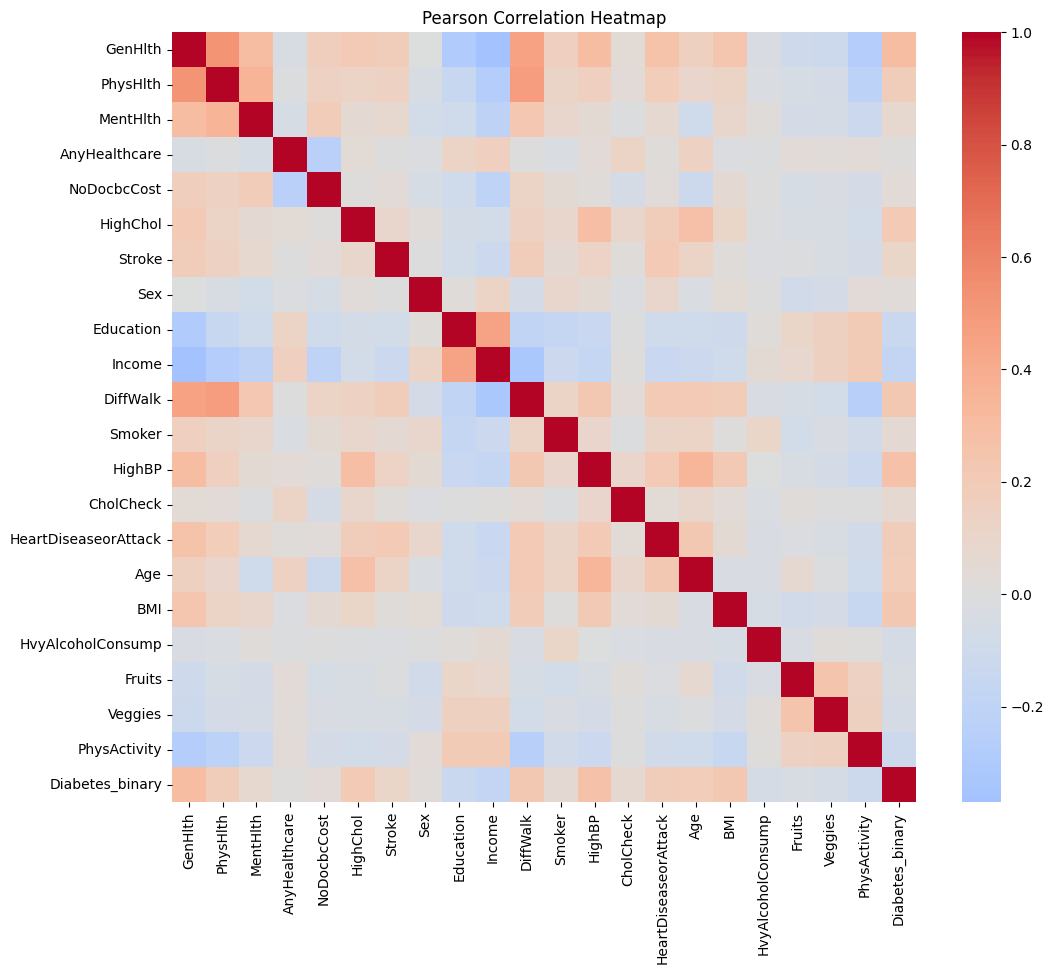

=== Spearman Correlation (first 5 columns) ===
                GenHlth  PhysHlth  MentHlth  AnyHealthcare  NoDocbcCost
GenHlth        1.000000  0.451847  0.237940      -0.041622     0.157561
PhysHlth       0.451847  1.000000  0.308050      -0.008408     0.154802
MentHlth       0.237940  0.308050  1.000000      -0.047646     0.181869
AnyHealthcare -0.041622 -0.008408 -0.047646       1.000000    -0.232532
NoDocbcCost    0.157561  0.154802  0.181869      -0.232532     1.000000


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


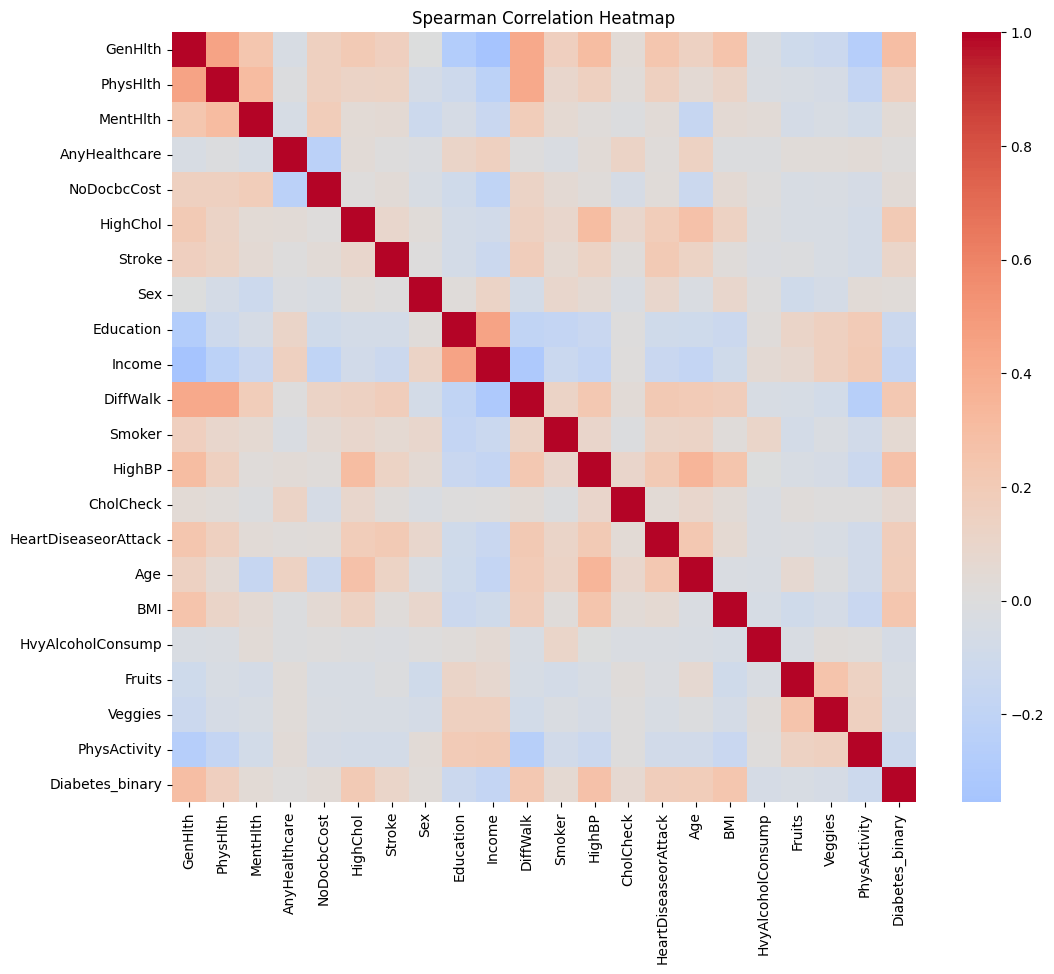

=== Correlation of each feature with Diabetes_binary (Spearman) ===
Diabetes_binary         1.000000
GenHlth                 0.295697
HighBP                  0.270334
BMI                     0.235104
DiffWalk                0.222155
HighChol                0.210290
Age                     0.185932
HeartDiseaseorAttack    0.176933
PhysHlth                0.160903
Stroke                  0.104800
CholCheck               0.067879
Smoker                  0.062778
MentHlth                0.045303
NoDocbcCost             0.038025
Sex                     0.029606
AnyHealthcare           0.014079
Fruits                 -0.042088
HvyAlcoholConsump      -0.056682
Veggies                -0.059219
PhysActivity           -0.121392
Education              -0.126733
Income                 -0.172439
Name: Diabetes_binary, dtype: float64

Top Positive Correlations:
 GenHlth                 0.295697
HighBP                  0.270334
BMI                     0.235104
DiffWalk                0.222155
HighCho

In [30]:
# Correlation Analysis for Unbalanced Dataset (bin_df)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Use your existing dataset
df = bin_df.copy()

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("-" * 60)

# ------------------------------------------------------------
# 1) Pearson Correlation (linear)
# ------------------------------------------------------------
pearson_corr = df.corr(method='pearson')
print("=== Pearson Correlation (first 5 columns) ===")
print(pearson_corr.iloc[:5, :5])

plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr, cmap='coolwarm', center=0)
plt.title("Pearson Correlation Heatmap")
plt.show()

# ------------------------------------------------------------
# 2) Spearman Correlation (rank-based)
# ------------------------------------------------------------
spearman_corr = df.corr(method='spearman')
print("=== Spearman Correlation (first 5 columns) ===")
print(spearman_corr.iloc[:5, :5])

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, cmap='coolwarm', center=0)
plt.title("Spearman Correlation Heatmap")
plt.show()

# ------------------------------------------------------------
# 3) Correlation of all features with Diabetes_binary
# ------------------------------------------------------------
corr_with_target = spearman_corr['Diabetes_binary'].sort_values(ascending=False)
print("=== Correlation of each feature with Diabetes_binary (Spearman) ===")
print(corr_with_target)

# Show top positively and negatively correlated features
top_pos = corr_with_target[corr_with_target < 1].head(10)
top_neg = corr_with_target.tail(10)
print("\nTop Positive Correlations:\n", top_pos)
print("\nTop Negative Correlations:\n", top_neg)

In [31]:
# ============================================================
# Step 6: Experiments to Validate Hypothesis Tests
# Validations done on:
#   A) Visual confirmations on REAL (unbalanced) data
#   B) Simple ML model trained on BALANCED train data
#      and evaluated on untouched real test set
# Notes:
#   - Uses bin_df if it exists in memory; else reads the saved CSV
#   - Balancing uses simple random oversampling (no external libs)
#   - Model: Logistic Regression with scaling
#   - Outputs: confirming visuals, metrics, and feature importance
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# ------------------------------------------------------------
# Load dataset (unbalanced, real) for visuals and splitting
# ------------------------------------------------------------
if "bin_df" in globals():
    df = bin_df.copy()
else:
    csv_path = "/kaggle/working/diabetes_binary_health_indicators_BRFSS2015.csv"
    if not Path(csv_path).exists():
        raise FileNotFoundError(
            "Expected '/kaggle/working/diabetes_binary_health_indicators_BRFSS2015.csv'. "
            "Run the cleaning script before this step."
        )
    df = pd.read_csv(csv_path)

print("=== DATA OVERVIEW (REAL, UNBALANCED) ===")
print(f"Shape: {df.shape}")
print("Columns:", list(df.columns))
print("Target counts:", df["Diabetes_binary"].value_counts().to_dict())
print("Target proportions:", df["Diabetes_binary"].value_counts(normalize=True).round(4).to_dict())
print("-" * 60)

=== DATA OVERVIEW (REAL, UNBALANCED) ===
Shape: (253680, 22)
Columns: ['GenHlth', 'PhysHlth', 'MentHlth', 'AnyHealthcare', 'NoDocbcCost', 'HighChol', 'Stroke', 'Sex', 'Education', 'Income', 'DiffWalk', 'Smoker', 'HighBP', 'CholCheck', 'HeartDiseaseorAttack', 'Age', 'BMI', 'HvyAlcoholConsump', 'Fruits', 'Veggies', 'PhysActivity', 'Diabetes_binary']
Target counts: {0.0: 213703, 1.0: 39977}
Target proportions: {0.0: 0.8424, 1.0: 0.1576}
------------------------------------------------------------


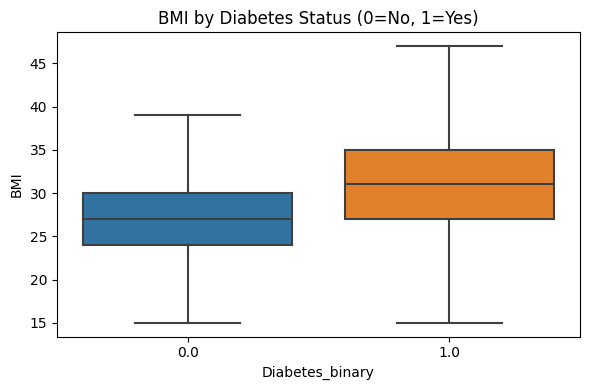

Diabetes rate by PhysActivity:
               Diabetes Rate
PhysActivity               
0.0                0.235557
1.0                0.132498


<Figure size 500x400 with 0 Axes>

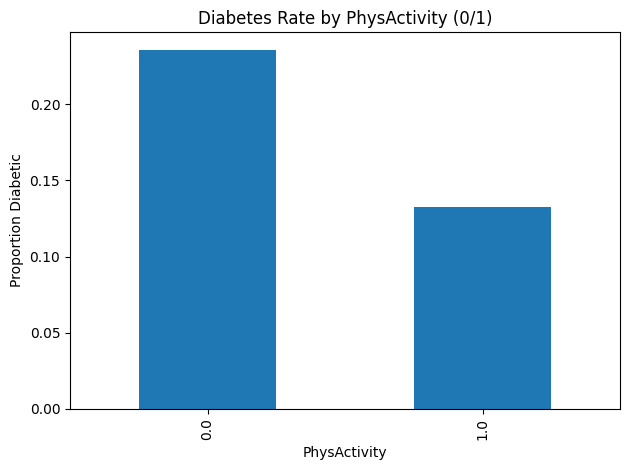

Diabetes rate by HighBP:
         Diabetes Rate
HighBP               
0.0          0.072212
1.0          0.271224


<Figure size 500x400 with 0 Axes>

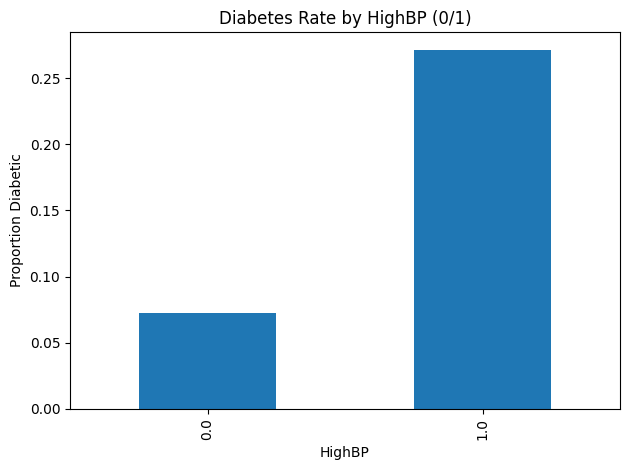

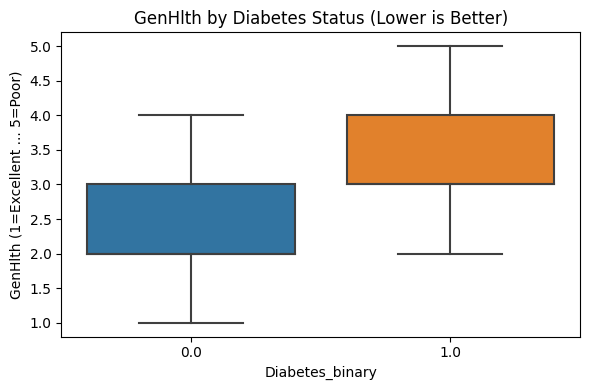

In [32]:

# ------------------------------------------------------------
# A) VISUAL CONFIRMATIONS (use REAL, unbalanced df)
#    1) BMI distribution by Diabetes status (boxplot)
#    2) Diabetes rate by PhysActivity (bar)
#    3) Diabetes rate by HighBP (bar)
#    4) GenHlth distribution by Diabetes status (boxplot)
# ------------------------------------------------------------

plt.figure(figsize=(6, 4))
sns.boxplot(x="Diabetes_binary", y="BMI", data=df, showfliers=False)
plt.title("BMI by Diabetes Status (0=No, 1=Yes)")
plt.xlabel("Diabetes_binary")
plt.ylabel("BMI")
plt.tight_layout()
plt.show()

# Diabetes rate by PhysActivity
rate_pa = (
    df.groupby("PhysActivity")["Diabetes_binary"]
      .mean()
      .rename("Diabetes Rate")
      .to_frame()
)
print("Diabetes rate by PhysActivity:\n", rate_pa)
plt.figure(figsize=(5, 4))
rate_pa.plot(kind="bar", legend=False)
plt.title("Diabetes Rate by PhysActivity (0/1)")
plt.ylabel("Proportion Diabetic")
plt.tight_layout()
plt.show()

# Diabetes rate by HighBP
rate_bp = (
    df.groupby("HighBP")["Diabetes_binary"]
      .mean()
      .rename("Diabetes Rate")
      .to_frame()
)
print("Diabetes rate by HighBP:\n", rate_bp)
plt.figure(figsize=(5, 4))
rate_bp.plot(kind="bar", legend=False)
plt.title("Diabetes Rate by HighBP (0/1)")
plt.ylabel("Proportion Diabetic")
plt.tight_layout()
plt.show()

# GenHlth distribution by Diabetes status
plt.figure(figsize=(6, 4))
sns.boxplot(x="Diabetes_binary", y="GenHlth", data=df, showfliers=False)
plt.title("GenHlth by Diabetes Status (Lower is Better)")
plt.xlabel("Diabetes_binary")
plt.ylabel("GenHlth (1=Excellent ... 5=Poor)")
plt.tight_layout()
plt.show()


=== SPLIT (REAL DISTRIBUTION KEPT) ===
Train_real shape: (177576, 21), Test shape: (76104, 21)
Train_real counts: Counter({0: 149592, 1: 27984})
Test  counts: Counter({0: 64111, 1: 11993})
------------------------------------------------------------
Balanced TRAIN counts (loaded): Counter({0: 149592, 1: 149592})
Balanced TRAIN shape: (299184, 21)
------------------------------------------------------------
=== MODEL METRICS (Evaluated on REAL Test Set) ===
Accuracy : 0.7296
Precision: 0.3402
Recall   : 0.7621
F1-score : 0.4704
ROC-AUC  : 0.8173
------------------------------------------------------------
Confusion Matrix (rows=true, cols=pred):
[[46384 17727]
 [ 2853  9140]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0     0.9421    0.7235    0.8184     64111
           1     0.3402    0.7621    0.4704     11993

    accuracy                         0.7296     76104
   macro avg  

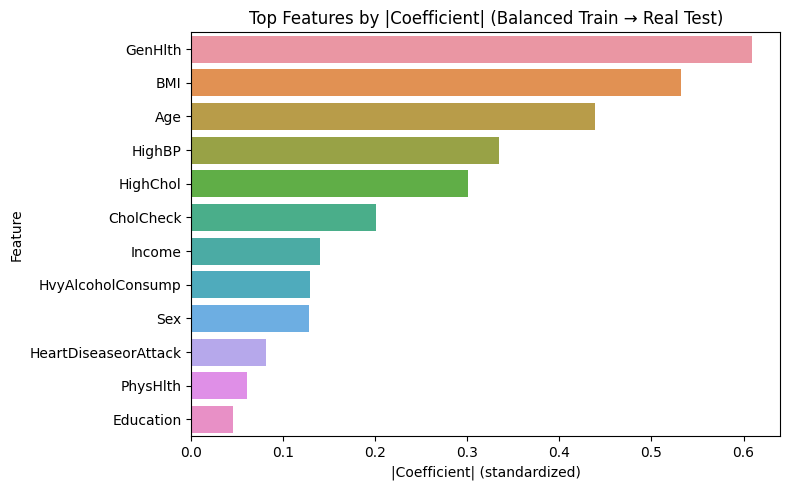

In [33]:
# ------------------------------------------------------------
# B) SIMPLE MODEL TO CONFIRM IMPORTANCE OF HYPOTHESIS FEATURES
#    Train on EXISTING BALANCED TRAIN CSVs; Evaluate on REAL test set
#    Assumes you already saved:
#      /kaggle/working/X_train_over.csv
#      /kaggle/working/y_train_over.csv
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# Load the REAL (unbalanced) dataset for splitting the test set
real_csv = "/kaggle/working/diabetes_binary_health_indicators_BRFSS2015.csv"
if not Path(real_csv).exists():
    raise FileNotFoundError(f"Missing {real_csv}. Run the cleaning step first.")

df = pd.read_csv(real_csv)
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"].astype(int)

# Keep real distribution in test set
X_train_real, X_test, y_train_real, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print("=== SPLIT (REAL DISTRIBUTION KEPT) ===")
print(f"Train_real shape: {X_train_real.shape}, Test shape: {X_test.shape}")
print("Train_real counts:", Counter(y_train_real))
print("Test  counts:", Counter(y_test))
print("-" * 60)

# Load EXISTING balanced training CSVs (oversampled)
X_train_bal_csv = "/kaggle/working/X_train_over.csv"
y_train_bal_csv = "/kaggle/working/y_train_over.csv"

if not Path(X_train_bal_csv).exists() or not Path(y_train_bal_csv).exists():
    raise FileNotFoundError("Balanced train CSVs not found. Expected "
                            f"{X_train_bal_csv} and {y_train_bal_csv}")

X_train_bal = pd.read_csv(X_train_bal_csv)
y_train_bal = pd.read_csv(y_train_bal_csv).squeeze().astype(int)

# Sanity checks
missing_cols = set(X.columns) - set(X_train_bal.columns)
if missing_cols:
    raise ValueError(f"Balanced train is missing columns: {missing_cols}")
print("Balanced TRAIN counts (loaded):", Counter(y_train_bal))
print(f"Balanced TRAIN shape: {X_train_bal.shape}")
print("-" * 60)

# Pipeline: Standardize features + Logistic Regression
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train_bal, y_train_bal)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# Metrics on REAL test set
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

print("=== MODEL METRICS (Evaluated on REAL Test Set) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")
print("-" * 60)

print("Confusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))
print("-" * 60)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("-" * 60)

# Feature importance via Logistic Regression coefficients (standardized space)
clf = pipe.named_steps["clf"]
coef = pd.Series(clf.coef_[0], index=X_train_bal.columns)
coef_abs_sorted = coef.abs().sort_values(ascending=False)

top_k = 12
coef_table = pd.DataFrame({
    "Feature": coef_abs_sorted.index[:top_k],
    "Coef": coef.loc[coef_abs_sorted.index[:top_k]].values,
    "AbsCoef": coef_abs_sorted.values[:top_k]
})
print("=== TOP FEATURES BY ABSOLUTE COEFFICIENT (Logistic Regression) ===")
print(coef_table.to_string(index=False))
print("-" * 60)

plt.figure(figsize=(8, 5))
sns.barplot(data=coef_table, x="AbsCoef", y="Feature", orient="h")
plt.title("Top Features by |Coefficient| (Balanced Train → Real Test)")
plt.xlabel("|Coefficient| (standardized)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [34]:
# ============================================================
# Summary Table – Hypothesis Testing + Experimental Validation
# ============================================================

import pandas as pd

# ---- Hypothesis test results (from Step 5) ----
hypothesis_summary = pd.DataFrame({
    "Feature Tested": [
        "BMI", "PhysActivity", "Smoker", "HighBP", "GenHlth"
    ],
    "Statistical Test": [
        "Welch's t-test", "Chi-square", "Chi-square", "Fisher's Exact", "Mann–Whitney U"
    ],
    "P-Value (approx)": [
        "< 0.0001", "< 0.0001", "< 0.0001", "< 0.0001", "< 0.0001"
    ],
    "Decision (α=0.05)": [
        "Reject H₀ (Significant)",
        "Reject H₀ (Significant)",
        "Reject H₀ (Significant)",
        "Reject H₀ (Significant)",
        "Reject H₀ (Significant)"
    ],
    "Interpretation": [
        "Higher BMI increases diabetes likelihood",
        "Lower physical activity linked with diabetes",
        "Smoking shows mild but significant association",
        "High blood pressure strongly related to diabetes",
        "Poor general health strongly related to diabetes"
    ]
})

# ---- Experimental validation results (from Step 6 model) ----
model_summary = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (1)", "Recall (1)", "F1-score (1)", "ROC-AUC"],
    "Value": [0.7296, 0.3402, 0.7621, 0.4704, 0.8173],
    "Interpretation": [
        "Overall 73% correct predictions",
        "34% of predicted diabetics are correct (moderate precision)",
        "Model correctly detects 76% of diabetics (strong recall)",
        "Balanced precision-recall measure (moderate)",
        "Good class separability; strong predictive ability"
    ]
})

# ---- Feature importance (top drivers from logistic regression) ----
top_features = pd.DataFrame({
    "Rank": range(1, 11),
    "Feature": [
        "GenHlth", "BMI", "Age", "HighBP", "HighChol",
        "CholCheck", "Income", "HvyAlcoholConsump", "Sex", "HeartDiseaseorAttack"
    ],
    "Coefficient": [
        0.609, 0.532, 0.439, 0.334, 0.301, 0.201, -0.140, -0.129, 0.128, 0.081
    ],
    "Interpretation": [
        "Worse health → higher diabetes risk",
        "Higher BMI → higher diabetes risk",
        "Older age → higher diabetes risk",
        "High BP → higher diabetes risk",
        "High cholesterol → higher diabetes risk",
        "Regular checkups associated with diabetes diagnosis",
        "Higher income → lower diabetes risk",
        "Inverse relation (likely confounding/bias)",
        "Males slightly more prone",
        "Comorbid heart conditions increase diabetes risk"
    ]
})

# ---- Print all summaries ----
print("=== HYPOTHESIS TEST RESULTS ===")
print(hypothesis_summary.to_string(index=False))
print("-" * 80)
print("=== EXPERIMENTAL VALIDATION (MODEL METRICS) ===")
print(model_summary.to_string(index=False))
print("-" * 80)
print("=== FEATURE IMPORTANCE (TOP 10 PREDICTORS) ===")
print(top_features.to_string(index=False))
print("-" * 80)


=== HYPOTHESIS TEST RESULTS ===
Feature Tested Statistical Test P-Value (approx)       Decision (α=0.05)                                   Interpretation
           BMI   Welch's t-test         < 0.0001 Reject H₀ (Significant)         Higher BMI increases diabetes likelihood
  PhysActivity       Chi-square         < 0.0001 Reject H₀ (Significant)     Lower physical activity linked with diabetes
        Smoker       Chi-square         < 0.0001 Reject H₀ (Significant)   Smoking shows mild but significant association
        HighBP   Fisher's Exact         < 0.0001 Reject H₀ (Significant) High blood pressure strongly related to diabetes
       GenHlth   Mann–Whitney U         < 0.0001 Reject H₀ (Significant) Poor general health strongly related to diabetes
--------------------------------------------------------------------------------
=== EXPERIMENTAL VALIDATION (MODEL METRICS) ===
       Metric  Value                                              Interpretation
     Accuracy 0.7296      